# Guided Project: Finding Heavy Traffic Indicators on I-94

In this guided project we're going to analyze a dataset about the westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94). To download the data set click [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#). 

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc.For instance, we may find out that the traffic is usually heavier in the summer or when it snows.


## The I-94 Traffic Dataset

The dataset documentation mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west). So we should avoid generalizing our results for the entire I-94 highway.


Attribute Information:

- holiday - Categorical US National holidays plus regional holiday, Minnesota State Fair
- temp - Numeric Average temp in kelvin
- rain_1h - Numeric Amount in mm of rain that occurred in the hour
- snow_1h - Numeric Amount in mm of snow that occurred in the hour
- clouds_all - Numeric Percentage of cloud cover
- weather_main - Categorical Short textual description of the current weather
- weather_description - Categorical Longer textual description of the current weather
- date_time - DateTime Hour of the data collected in local CST time
- traffic_volume - Numeric Hourly I-94 ATR 301 reported westbound traffic volume


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

#Examine the first five rows.

data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
# Examine the last five rows.
data.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [4]:
#let's find more information about the dataset.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


## Analyzing Traffic Volume

Let's plot a histogram to examine the distribution of the traffic_volume column


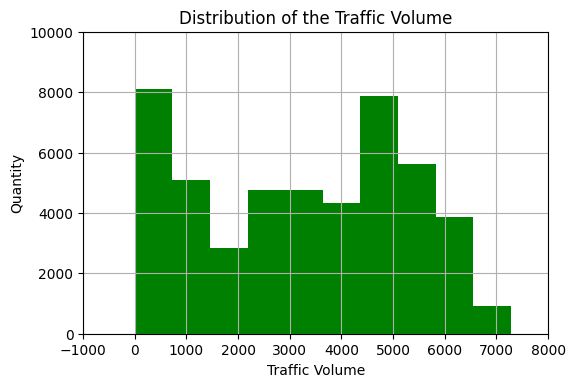

In [5]:
plt.hist(data['traffic_volume'], color='green')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Distribution of the Traffic Volume')
plt.xlim(-1000, 8000)
plt.ylim(0, 10000)
plt.grid(True)
plt.show()

Next we will look up a few statistics about the traffic_volume column.

In [6]:
data['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

As we see:  

- about 25% of the time, there were 1,193 cars or fewer passing the station each hour — this probably occurs during the night, or when a road is under construction.
- about 75% of the time, the traffic volume was four times as much (4,933 cars or more).



Now let's group by intervals with step 1000 the traffic_volume column to find out the quantity of distribution.

In [7]:
intervals = pd.interval_range(start=0, end=8000, freq=1000)
data_freq_table = pd.Series([0,0,0,0,0,0,0,0], index=intervals)
for value in data['traffic_volume']:
    for interval in intervals:
        if value in interval:
            data_freq_table.loc[interval] += 1
            break
            
print(data_freq_table)            

(0, 1000]       10993
(1000, 2000]     4228
(2000, 3000]     6301
(3000, 4000]     5746
(4000, 5000]     9592
(5000, 6000]     7840
(6000, 7000]     3441
(7000, 8000]       61
dtype: int64


Based on our observations we can say that the biggest traffic volume is in interval 0-1000 and the second one is in 4000-5000. The mean of the traffic volume is 3259.82. Let's explore this data concerning daytime and nighttime influence.

## Traffic Volume: Day vs. Night

Let's compare daytime with nighttime data. We'll start by dividing the dataset into two parts:

- Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
- Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

While this is not a perfect criterion for distinguishing between nighttime and daytime, it's a good starting point.

In [8]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [9]:
day = data.copy()[(data['date_time'].dt.hour >= 7) & (data['date_time'].dt.hour < 19)]
print(day.shape)

night = data.copy()[(data['date_time'].dt.hour >= 19) | (data['date_time'].dt.hour < 7)]
print(night.shape)


(23877, 9)
(24327, 9)


## Traffic Volume: Day vs. Night (II)

Now we're going to compare the traffic volume at night and during day.

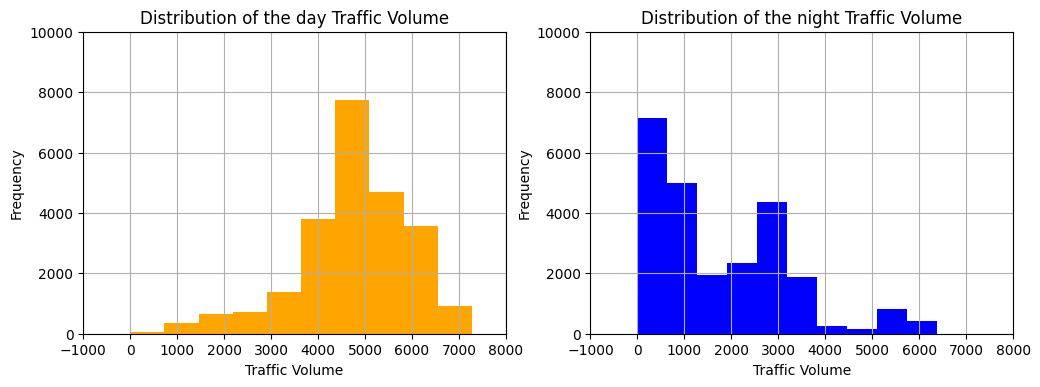

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'], color='orange')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Distribution of the day Traffic Volume')
plt.xlim(-1000, 8000)
plt.ylim(0, 10000)
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'], color='blue')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Distribution of the night Traffic Volume')
plt.xlim(-1000, 8000)
plt.ylim(0, 10000)
plt.grid(True)
plt.show()

In [19]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [20]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

As we see the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so we will decide to only focus on the daytime data moving forward.

## Time Indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

- Month
- Day of the week
- Time of day

In the code below, we'll do the following:

- Use **day['date_time'].dt.month** to create a new column where each value describes the month when the traffic volume measurement was taken.
- Use **day.groupby('month').mean()** to group the dataset by the month column with the mean as an aggregate function.


In [21]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

Let's generate the plot for the first time unit mentioned above — the month.

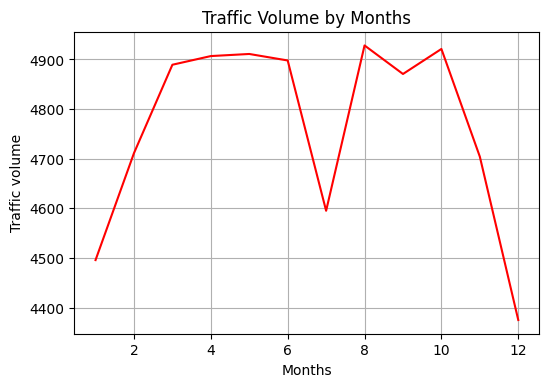

In [33]:
plt.figure(figsize=(10,6))
by_month['traffic_volume'].plot.line(color='red')
plt.xlabel('Months')
plt.ylabel('Traffic volume')
plt.title('Traffic Volume by Months')
plt.grid(True)
plt.show()


And here on a plot we see interesting thing: in a June and July traffic volume reduces. In August traffic volume is getting increase. Maybe it depends on to summer vacations. Generally the traffic is usually heavier during warm months (March–October) compared to cold months (November–February).

##  Time Indicators (II)

We'll now continue with building line plots for another time unit: day of the week.

In [34]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

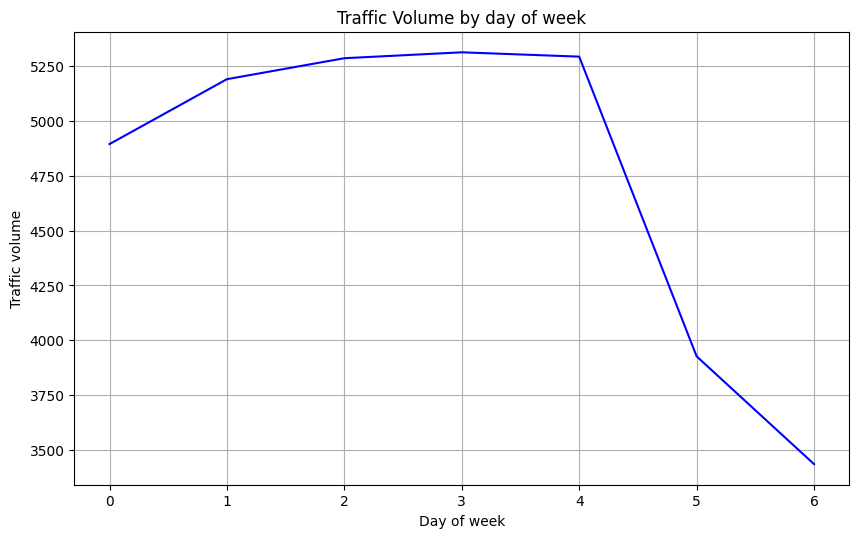

In [38]:
plt.figure(figsize=(10,6))
by_dayofweek['traffic_volume'].plot.line(color='blue')
plt.xlabel('Day of week')
plt.ylabel('Traffic volume')
plt.title('Traffic Volume by day of week')
plt.grid(True)
plt.show()

As we expected there are difference between business days and the weekend. The lowest traffic volume is in weekend.

## Time Indicators (III)

We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. To do that, we'll start by splitting the data based on the day type: business day or weekend.

In [39]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


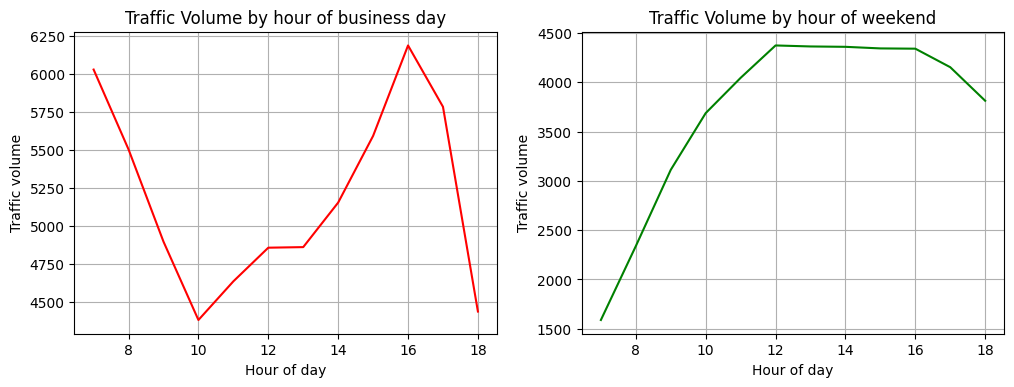

In [42]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot.line(color='red')
plt.xlabel('Hour of day')
plt.ylabel('Traffic volume')
plt.title('Traffic Volume by hour of business day')
plt.grid(True)

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot.line(color='green')
plt.xlabel('Hour of day')
plt.ylabel('Traffic volume')
plt.title('Traffic Volume by hour of weekend')
plt.grid(True)

plt.show()

On the first plot 'Traffic Volume by hour of business day' we see heavy traffic on the rush hours (7 a.m till 9 a.m. and 3 p.m. till 5 p.m.)

## Weather Indicators

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: temp, rain_1h, snow_1h, clouds_all, weather_main, weather_description.

A few of these columns are numerical so let's start by looking up their correlation values with traffic_volume.

In [43]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

Temperature shows the strongest correlation with a value of just +0.13. The other relevant columns (rain_1h, snow_1h, clouds_all) don't show any strong correlation with traffic_value.

Let's generate a scatter plot to visualize the correlation between temp and traffic_volume.

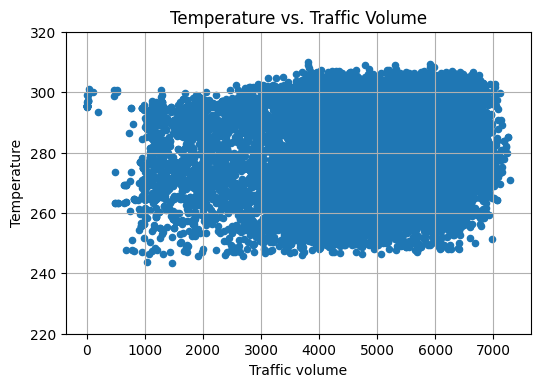

In [62]:
day.plot.scatter('traffic_volume', 'temp')
plt.ylim(220, 320)
plt.xlabel('Traffic volume')
plt.ylabel('Temperature')
plt.title('Temperature vs. Traffic Volume')
plt.grid(True)
plt.show()

We examined the correlation between traffic_volume and the numerical weather columns. However, there is no any reliable indicator of heavy traffic.

## Weather Types

To see if we can find more useful data, we'll look next at the categorical weather-related columns: weather_main and weather_description. We're going to calculate the average traffic volume associated with each unique value in these two columns. 

In [63]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_description = day.groupby('weather_description').mean()

Let's create a bar plot for the traffic_volume column of by_weather_main and by_weather_description

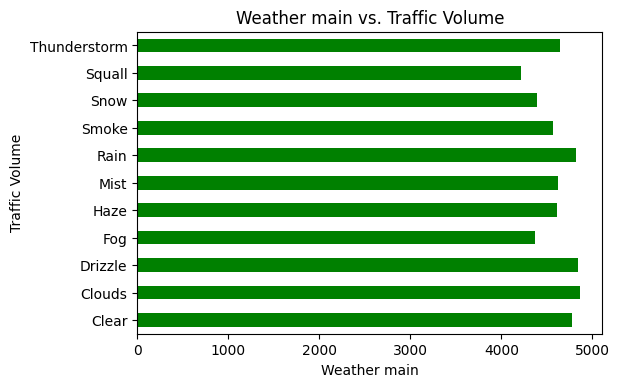

In [69]:
by_weather_main['traffic_volume'].plot.barh(color='green')

plt.xlabel('Weather main')
plt.ylabel('Traffic Volume')
plt.title('Weather Main vs. Traffic Volume')
plt.show()

It looks like there's no weather type where traffic volume exceeds 5,000 cars. This makes finding a heavy traffic indicator more difficult.

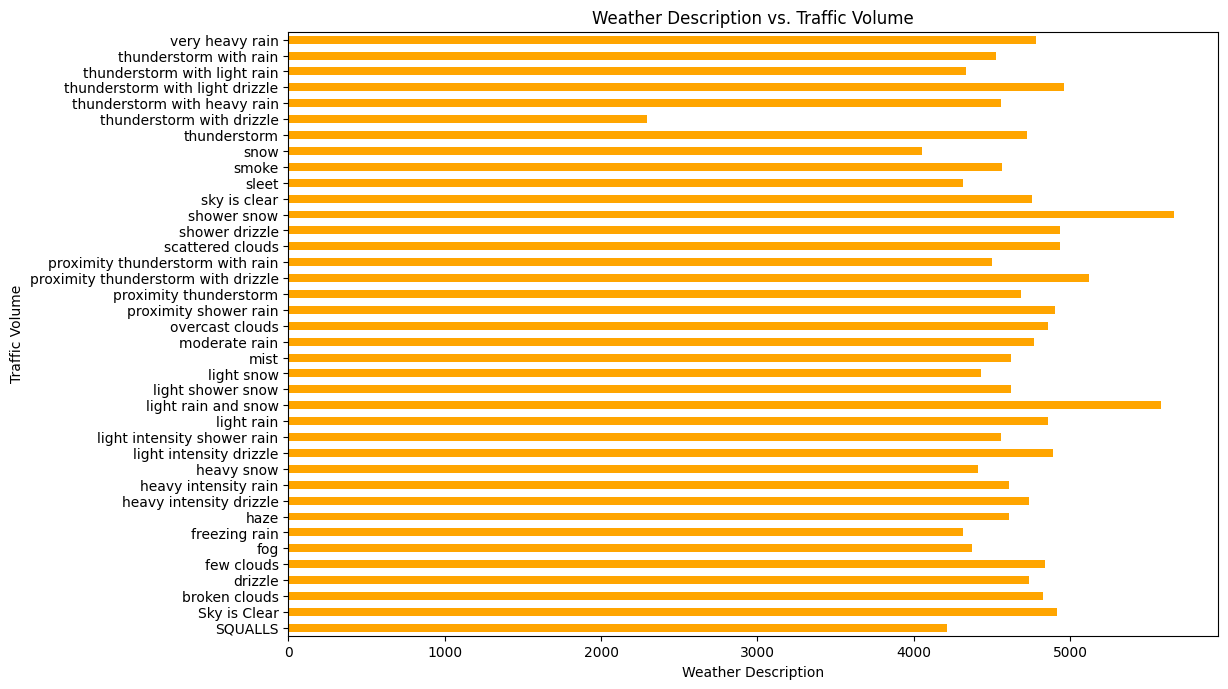

In [72]:
plt.figure(figsize=(12, 8))
by_weather_description['traffic_volume'].plot.barh(color='orange')

plt.xlabel('Weather Description')
plt.ylabel('Traffic Volume')
plt.title('Weather Description vs. Traffic Volume')
plt.show()

As we see the lowest traffic volume occur when the weather is thunderstorm with drizzle.

It looks like there are three weather types where traffic volume exceeds 5,000:

- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle

## Conclusion

In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:

- Time indicators
  - The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
  - The traffic is usually heavier on business days compared to the weekends.
  - On business days, the rush hours are around 7 and 16.
  
- Weather indicators
  - Shower snow
  - Light rain and snow
  - Proximity thunderstorm with drizzle


